In [208]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import cufflinks as cf
import os
from toolz.functoolz import curry, pipe
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from shapely.geometry import Point, Polygon

cf.set_config_file(offline=False, world_readable=True, theme='ggplot')

% matplotlib inline

# Read Data

In [24]:
def read_shapefile(path, fname):
    return gpd.read_file(os.path.join(path, fname))

# Data specific to aleppo damage dataset
aleppo_path = os.path.join("..", "data", "syria_damage_aleppo")
neighborhoods = read_shapefile(aleppo_path, "Neighborhoods.shp")
cityborder = read_shapefile(aleppo_path, "CityBorder.shp")
dmg_sites = read_shapefile(aleppo_path, "Damage_sites_Update3_Aleppo_20150426.shp")
neigh_perc_dmg = read_shapefile(aleppo_path, "Aleppo_Neighborhood_PercentDamage.shp")

# General Syria boundary data
admin_boundary_path = os.path.join("..", "data", "syria_admin_boundaries")
boundaries = read_shapefile(admin_boundary_path, "SYR_adm1.shp")

# Global Exposure Data
ged_path = os.path.join("..", "data", "syria_global_exposure_dataset")
ged = read_shapefile(ged_path, "gar_exp_SYR.shp")

# Contextualize Data

Now we want to situate ourselves so that we can identify where in Syria we are focusing

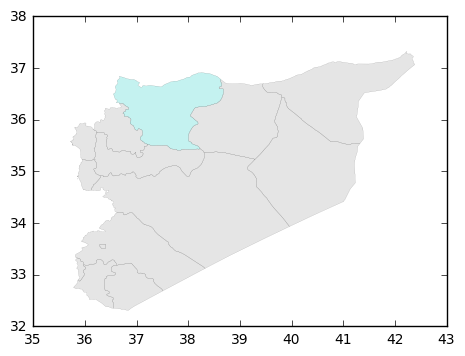

In [647]:
class PlotPipeline(object):
    
    def __init__(self, base_geodataframe, **base_options):
        self.base_plot = curry(
            base_geodataframe.plot, **base_options)
        self.pipeline = []
        
    def add(self, geodataframe, **plot_options):
        self.pipeline.append(
            self.chain_plot_func(geodataframe, plot_options))
        return self
        
    def plot(self):
        return pipe(self.base_plot(), *self.pipeline)
        
    @staticmethod
    def chain_plot_func(geodataframe, plot_options):
        def chain_plot_func_wrapper(base_plot):
            return geodataframe.plot(ax=base_plot, **plot_options)
        return chain_plot_func_wrapper


aleppo_governate = boundaries[boundaries.NAME_1 == "Aleppo"]
PlotPipeline(boundaries, color="#cccccc", linewidth=0.05)\
    .add(aleppo_governate, color="#a5fffc", linewidth=0)\
    .plot();

# Understanding the Damage Data

Before trying to ask deeper questions of the data as a whole, it's always useful to understand seperately what's inside the smaller pieces, in this case the nine sets of shapefiles and their associated metadata:

```
Aleppo_Neighborhood_PercentDamage.shp
CityBorder.shp
Damage_sites_Update3_Aleppo_20150426.shp
Damage_sites_Update3_Daraa_20150604.shp
Damage_sites_Update3_Deir_Ez_Zor_20150510.shp
Damage_sites_Update3_Idlib_20150406.shp
Damage_sites_Update3_Raqqa_20150529.shp
Neighborhoods.shp
```

In [4]:
cont_perc_dmg.head()

,Id,OBJECTID,Shape_Area,Shape_Leng,geometry,gridcode
0,1,1,2.006787e-08,0.000626,"POLYGON ((37.15666601500004 36.29590355300007,...",1
1,2,2,1.003388e-08,0.000403,"POLYGON ((37.15677732800009 36.29590527000005,...",2
2,3,3,2.006786e-08,0.000626,"POLYGON ((37.15699995500006 36.29590870200008,...",1
3,4,4,1.003383e-08,0.000403,"POLYGON ((37.15633419500006 36.29580829400004,...",2
4,5,5,1.003392e-08,0.000403,"POLYGON ((37.15644550900004 36.29581001100007,...",4


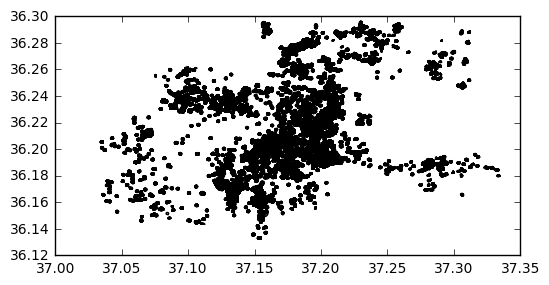

In [68]:
cont_perc_dmg.plot()

### Zooming into

the province of Aleppo, we want to see the distribution of buildings that have been damaged.

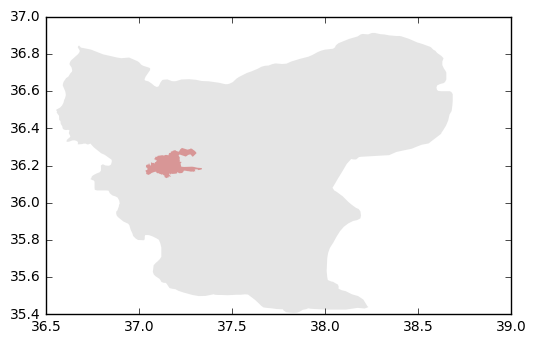

In [661]:
aleppo_cityborder = cityborder[cityborder.Name == "Aleppo"]
PlotPipeline(aleppo_governate, color="#cccccc", linewidth=0)\
    .add(aleppo_cityborder, color="#cc4949", linewidth=0)\
    .plot();

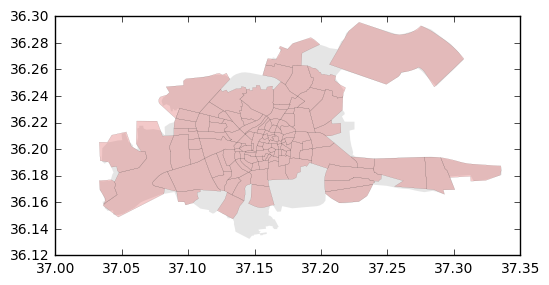

In [667]:
aleppo_nhoods = neighborhoods[neighborhoods.Settlement == "Aleppo"]
PlotPipeline(aleppo_cityborder, color="#cccccc", linewidth=0)\
    .add(aleppo_nhoods, color="#e27a7a", linewidth=0.05,
         alpha=0.4)\
    .plot();

In [411]:
dmg_sites.head()

,Confiden_1,Confiden_2,Confidence,Damage_S_1,Damage_Sta,EventCode,FieldValid,Grouped_Da,Main_Dam_1,Main_Dam_2,...,Notes,SensorDa_1,SensorDa_2,SensorDate,SensorID,SensorID_2,SensorID_3,Settlement,SiteID,geometry
0,1,1,None,0,New - damage,CE20130604SYR,Not yet field validated,Damaged Buildings,2,2,...,None,2014-05-23,2015-04-26,None,None,Worldview-2,Pleiades,Aleppo,Building (General / Default),POINT (37.15776331000006 36.20329602200007)
1,1,1,None,0,New - damage,CE20130604SYR,Not yet field validated,Damaged Buildings,2,2,...,None,2014-05-23,2015-04-26,None,None,Worldview-2,Pleiades,Aleppo,Building (General / Default),POINT (37.15755938700005 36.20334018500006)
2,1,1,None,0,New - damage,CE20130604SYR,Not yet field validated,Damaged Buildings,2,2,...,None,2014-05-23,2015-04-26,None,None,Worldview-2,Pleiades,Aleppo,Building (General / Default),POINT (37.15748426800008 36.20334353300007)
3,1,1,None,0,New - damage,CE20130604SYR,Not yet field validated,Damaged Buildings,1,1,...,None,2014-05-23,2015-04-26,None,None,Worldview-2,Pleiades,Aleppo,Building (General / Default),POINT (37.15766302800006 36.20330574000008)
4,1,1,None,0,New - damage,CE20130604SYR,Not yet field validated,Damaged Buildings,1,1,...,None,2014-05-23,2015-04-26,None,None,Worldview-2,Pleiades,Aleppo,Building (General / Default),POINT (37.15756589100005 36.20235143000008)


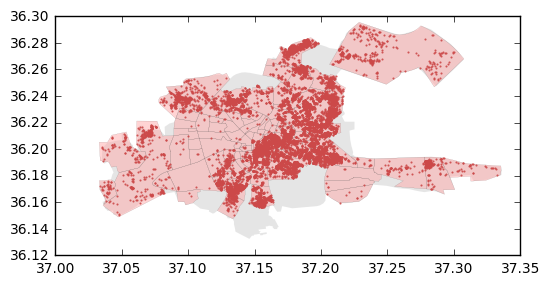

In [108]:
PlotPipeline(aleppo_cityborder, color="#cccccc", linewidth=0)\
    .add(aleppo_nhoods, color="#ffaaaa", linewidth=0.05)\
    .add(dmg_sites, color="#cc4949", marker="o",
         markersize=1.5, markeredgewidth=0.0, alpha=0.9)\
    .plot()

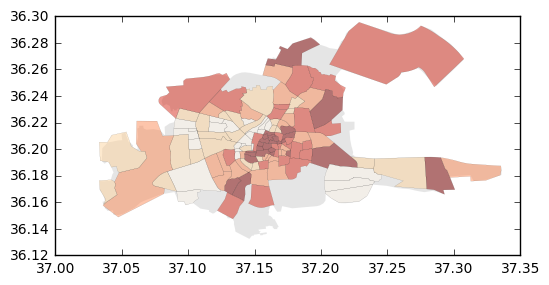

In [109]:
PlotPipeline(aleppo_cityborder, color="#cccccc", linewidth=0)\
    .add(neigh_perc_dmg, column="Percent_1", cmap="OrRd",
         linewidth=0.05, scheme='quantiles')\
    .plot()

In [421]:
df = pd.DataFrame(dmg_sites.SiteID.value_counts())\
    .sort_values("SiteID")
df.iplot(kind="barh", margin=dict(l=200),
         title="Absolute number of buildings damaged")

# Global Exposure Dataset

This dataset represents a 5x5km resolution grid breakdown of the territory within Syria, where each grid block contains metadata about the people and infrastructure.

In [28]:
ged.head()

,bed_prv_cr,bed_prv_cu,bed_prv_pr,bed_prv_pu,bed_pub_cr,bed_pub_cu,bed_pub_pr,bed_pub_pu,edu_prv_cr,edu_prv_cu,...,ic_mlw_pr,ic_mlw_pu,id_5x,iso3,tot_cr,tot_cu,tot_pob,tot_pr,tot_pu,tot_val
0,0.0081,0.0,1.856,0.0,0.0060,0.0,1.385,0.0,0.1639,0.0,...,1623.3,0.0,4774462,SYR,16.9223,0.0,3898.040,3898.040,0.0,16.9223
1,0.0026,0.0,0.438,0.0,0.0019,0.0,0.327,0.0,0.0527,0.0,...,383.2,0.0,4774463,SYR,5.4134,0.0,920.165,920.165,0.0,5.4134
2,0.0018,0.0,0.340,0.0,0.0014,0.0,0.254,0.0,0.0374,0.0,...,297.5,0.0,4774464,SYR,3.8458,0.0,714.394,714.394,0.0,3.8458
3,0.0014,0.0,0.329,0.0,0.0011,0.0,0.246,0.0,0.0289,0.0,...,288.1,0.0,4774465,SYR,3.0035,0.0,691.775,691.775,0.0,3.0035
4,0.0033,0.0,0.750,0.0,0.0024,0.0,0.560,0.0,0.0666,0.0,...,656.4,0.0,4778177,SYR,6.8431,0.0,1576.310,1576.310,0.0,6.8431


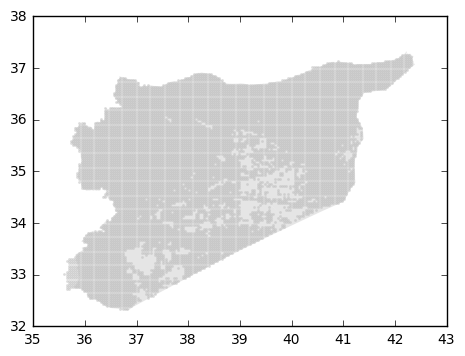

In [48]:
PlotPipeline(boundaries, color="#cccccc", linewidth=0)\
    .add(ged, color="#bbbbbb", markeredgewidth=0.0, alpha=0.5)\
    .plot()

Each column is composed of three labels that are '_' separated. Here we do a little column relabelling so that we can make exploring the data easier.

In [516]:
column_codes = {
    "bed": "health",
    "edu": "education",
    "emp": "employment",
    "ic": "housing",
    "prv": "private",
    "pub": "public",
    "agr": "agriculture",
    "gov": "government",
    "ind": "industrial",
    "ser": "service",
    "high": "high_income",
    "low": "low_income",
    "mhg": "upper_middle",
    "mlw": "lower_middle",
    "cr": "capital_rural",
    "cu": "capital_urban",
    "pu": "pop_urban",
    "pr": "pop_rural",
    "tot": "total",
    "pob": "population",
    "val": "capital_stock"
}

def column_code_to_label(col, codes=column_codes):
    return "_".join([codes[c] if codes.get(c, None)
                    else c for c in col.split("_")])

column_names = map(column_code_to_label, ged.columns)
ged = ged.rename(
    columns=dict(zip(ged.columns, column_names)))

In [517]:
ged.head()

,health_private_capital_rural,health_private_capital_urban,health_private_pop_rural,health_private_pop_urban,health_public_capital_rural,health_public_capital_urban,health_public_pop_rural,health_public_pop_urban,education_private_capital_rural,education_private_capital_urban,...,housing_lower_middle_pop_rural,housing_lower_middle_pop_urban,id_5x,iso3,total_capital_rural,total_capital_urban,total_population,total_pop_rural,total_pop_urban,total_capital_stock
0,0.0081,0.0,1.856,0.0,0.0060,0.0,1.385,0.0,0.1639,0.0,...,1623.3,0.0,4774462,SYR,16.9223,0.0,3898.040,3898.040,0.0,16.9223
1,0.0026,0.0,0.438,0.0,0.0019,0.0,0.327,0.0,0.0527,0.0,...,383.2,0.0,4774463,SYR,5.4134,0.0,920.165,920.165,0.0,5.4134
2,0.0018,0.0,0.340,0.0,0.0014,0.0,0.254,0.0,0.0374,0.0,...,297.5,0.0,4774464,SYR,3.8458,0.0,714.394,714.394,0.0,3.8458
3,0.0014,0.0,0.329,0.0,0.0011,0.0,0.246,0.0,0.0289,0.0,...,288.1,0.0,4774465,SYR,3.0035,0.0,691.775,691.775,0.0,3.0035
4,0.0033,0.0,0.750,0.0,0.0024,0.0,0.560,0.0,0.0666,0.0,...,656.4,0.0,4778177,SYR,6.8431,0.0,1576.310,1576.310,0.0,6.8431


Next we filter datapoints in the global exposure dataset that are within the aleppo city border.

In [518]:
# compute a bounding box so that we can figure out
# the ged rows that are in Aleppo
polygon = aleppo_cityborder.geometry.iloc[0]
minx, miny, maxx, maxy = polygon.bounds
aleppo_bounds = Polygon([
    (minx, miny),
    (minx, maxy),
    (maxx, maxy),
    (maxx, miny)
])

allepo_ged = ged[ged.geometry.within(aleppo_bounds)]
allepo_ged.shape

(28, 57)

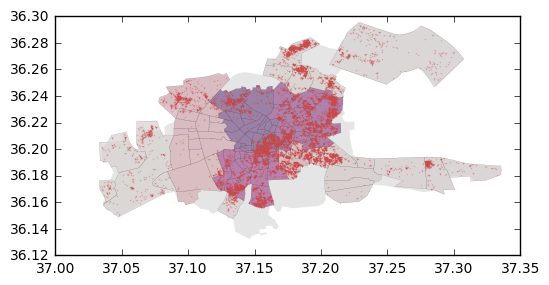

In [643]:
def create_cityborder():
    return PlotPipeline(
        aleppo_cityborder, color="#cccccc", linewidth=0)\
        .add(aleppo_nhoods, color="#aaaaaa", linewidth=0.05)

def agg_columns(geodf, pattern, agg_col_name):
    df = geodf.copy()
    patt = pattern.split("|")
    sel = df[[c for c in df.columns
              if all([p in c for p in patt])]]
    df.loc[:, agg_col_name] = sel.sum(axis=1).copy()
    return df

def compute_min_distance(centroid, points):
    return points.distance(centroid)\
        .sort_values(ascending=True).index[0]

# add aggregated housing population
mod_allepo_ged = allepo_ged\
    .pipe(agg_columns, "housing|pop", "total_housing_pop")\
    .pipe(agg_columns, "housing|cap", "total_housing_cap")
    
# Compute index to join with ged data to give a rough
# view of the aggregate statistics by neighborhood
aleppo_nhoods.loc[:, "join_idx"] = aleppo_nhoods.geometry.centroid.apply(lambda x:
    compute_min_distance(x, allepo_ged.geometry))
mod_allepo_ged.drop("geometry",  axis=1)
ged_aleppo_nhoods = aleppo_nhoods.merge(
    mod_allepo_ged.drop("geometry",  axis=1),
    how="inner", left_on="join_idx", right_index=True)\
    .pipe(gpd.GeoDataFrame)
    
create_cityborder()\
    .add(ged_aleppo_nhoods, column="total_housing_pop",
         linewidth=0.0, alpha=0.35, cmap="RdPu")\
    .add(dmg_sites, color="#cc4949", marker="1",
         markersize=1.5, markeredgewidth=0.2, alpha=0.65)\
    .plot()

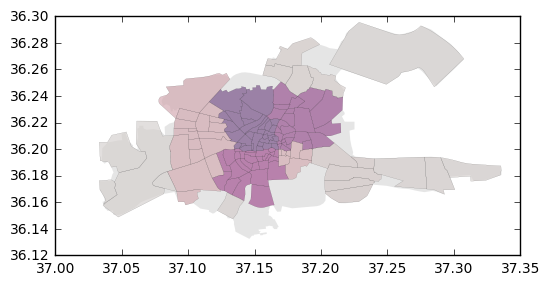

In [648]:
create_cityborder()\
    .add(ged_aleppo_nhoods, column="total_housing_pop",
         linewidth=0.0, alpha=0.35, cmap="RdPu")\
    .plot()

In [687]:
allepo_ged.head()

,health_private_capital_rural,health_private_capital_urban,health_private_pop_rural,health_private_pop_urban,health_public_capital_rural,health_public_capital_urban,health_public_pop_rural,health_public_pop_urban,education_private_capital_rural,education_private_capital_urban,...,housing_lower_middle_pop_rural,housing_lower_middle_pop_urban,id_5x,iso3,total_capital_rural,total_capital_urban,total_population,total_pop_rural,total_pop_urban,total_capital_stock
1793,0.0490,0.0359,7.376,5.516,0.0366,0.0268,5.506,4.118,0.9975,0.7651,...,6451.6,4824.5,4863966,SYR,102.8300,76.8976,27077.90,15492.50,11585.4,179.7276
1794,0.0344,0.1475,4.975,21.840,0.0256,0.1101,3.714,16.303,0.6992,3.1468,...,4351.3,19102.0,4863967,SYR,72.0608,316.3390,56319.90,10449.20,45870.7,388.3998
1795,0.0246,0.0450,3.637,6.799,0.0184,0.0336,2.715,5.075,0.5003,0.9601,...,3180.8,5946.7,4863968,SYR,51.6008,96.4726,21918.25,7638.15,14280.1,148.0734
1796,0.0432,0.1537,6.253,22.738,0.0322,0.1147,4.668,16.973,0.8790,3.2777,...,5469.1,19887.5,4863969,SYR,90.5984,329.4420,60890.50,13133.50,47757.0,420.0404
1797,0.0123,0.0000,1.837,0.000,0.0092,0.0000,1.372,0.000,0.2511,0.0000,...,1607.1,0.0,4863970,SYR,25.8668,0.0000,3859.21,3859.21,0.0,25.8668


In [711]:
tot_stock = allepo_ged.total_capital_stock.sum() / (1 * pow(10, 3))
print("${} Total Capital Stock in Aleppo").format(
    round(tot_stock, 1))

$29.5 Total Capital Stock in Aleppo


In [713]:
tot_pop = allepo_ged.total_pop_urban.sum() / (1 * pow(10, 6))
print("Estimated Population in Aleppo: {}").format(round(tot_pop, 1))

Estimated Population in Aleppo: 4.1
